In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
import numpy as np
import h5py
import sys
sys.path.append(os.getenv('PYTHONPATH')) 
import h5py
import cv2
import matplotlib.pyplot as plt

#local
from src.utils.transforms import SelectROIs

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
root = os.path.join(os.getenv("DATASETS_ROOT", "/default/path/to/datasets"), "MOSAIC")
project_root = os.path.join(os.getenv("PROJECT_ROOT"))
print(f"root: {root}")
print(f"project root: {project_root}")
config = {
    'fmri': {
        'rois': [f"GlasserGroup_{x}" for x in range(1,6)],
    }
}

root: /data/vision/oliva/datasets/MOSAIC
project root: /data/vision/torralba/selfmanaged/oliva/u/blahner/projects/MOSAIC


In [13]:
def visual_angle_transform(image, angle_degrees, preserve_size=True):
    """
    Transform an image based on visual angle with range checking
    """
    # Verify input image range
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    
    height, width = image.shape[:2]
    angle_rad = np.deg2rad(angle_degrees)
    
    # Calculate transformation parameters
    offset = int(width * np.tan(angle_rad/4))
    
    pts1 = np.float32([
        [0, 0],
        [width-1, 0],
        [0, height-1],
        [width-1, height-1]
    ])
    
    pts2 = np.float32([
        [offset, 0],
        [width-offset, 0],
        [0, height-1],
        [width-1, height-1]
    ])
    
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    transformed = cv2.warpPerspective(image, matrix, (width, height))
    
    if preserve_size:
        transformed = cv2.resize(transformed, (width, height))
    
    # Verify output is in correct range
    transformed = np.clip(transformed, 0, 255).astype(np.uint8)
    
    return transformed

def apply_fov(image, fov_angle):
    """Applies a field of view effect to an image."""

    height, width = image.shape[:2]
    fov_angle_rad = np.radians(fov_angle)

    # Calculate the focal length based on the FOV angle
    focal_length = width / (2 * np.tan(fov_angle_rad / 2))

    # Create a transformation matrix for the perspective
    K = np.array([
        [focal_length, 0, width / 2],
        [0, focal_length, height / 2],
        [0, 0, 1]
    ])

    # Apply the perspective transformation
    warped_image = cv2.warpPerspective(image, K, (width, height))

    return warped_image

def display_comparison(original, transformed):
    """
    Display original and transformed images side by side
    """
    # Convert BGR to RGB if using cv2.imread()
    if len(original.shape) == 3:  # Color image
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        transformed = cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    ax1.imshow(original)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Display transformed image
    ax2.imshow(transformed)
    ax2.set_title('Transformed Image')
    ax2.axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

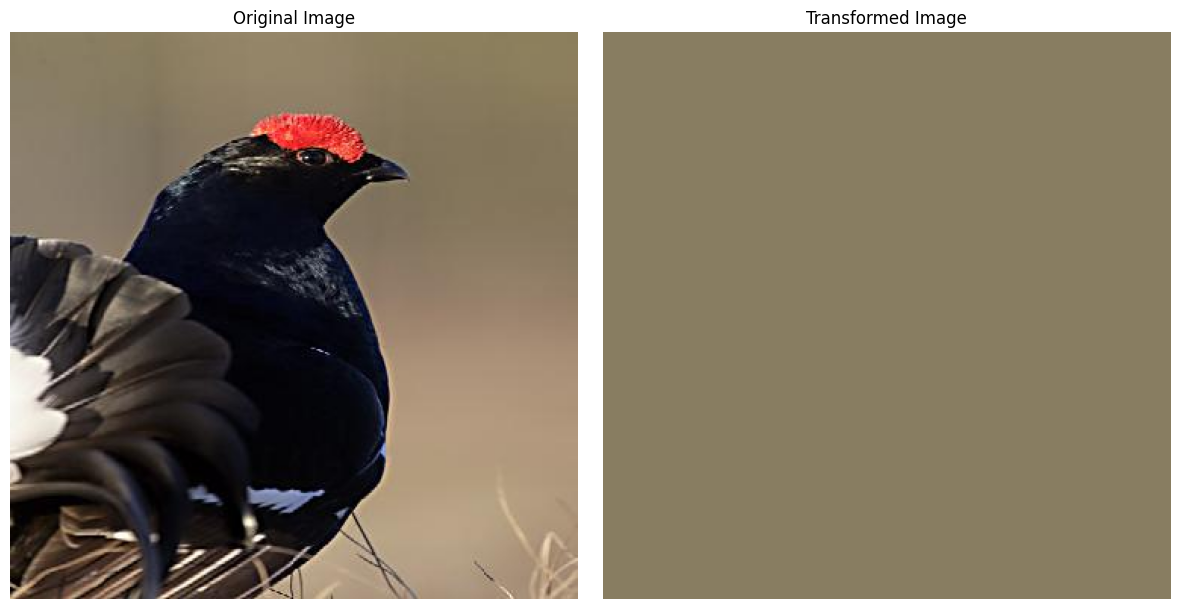

In [ ]:
image = cv2.imread(os.path.join(root, 'stimuli', 'raw', 'n01795545_6290.JPEG'))

# Apply transformation
#transformed = visual_angle_transform(image, angle_degrees=30)
transformed = apply_fov(image, fov_angle=20)

# Display comparison
display_comparison(image, transformed)